In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# import libraries
import numpy as np 
import pandas as pd
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt
import os.path

In [3]:
def availablePath(generations, limit): # find available path to save data in Excel
    location = "Data\\" + "ExtensionModel"  +  "-" + "Gen" + str(generationsT) + "-" + "Lim" + str(limit) + ".xlsx"
    version = 1
    while os.path.isfile(location):
        location = "Data\\" + "ExtensionModel"  +  "-" + "Gen" + str(generationsT) + "-" + "Lim" + str(limit) + "-" + str(version) + ".xlsx"
        version += 1
    return location

In [4]:
def storeToExcel(limit): # store generated data to an Excel file
    d = {'Generations' : generationsPlot, 'nrQuestions' : nrQuestions, 'nrQuestionsPub' : nrQuestionsPub,
         'meanPayoffs' : meanPayoffs, 'meanSampleSizes' : meanSampleSizes, 'meanPublished' : meanPublished, 'meanPower' : meanPower, 'meanPowerPub' : meanPowerPub,
         'nrTruePos': nrTruePos, 'nrTrueNeg' : nrTrueNeg, 'nrTruePosPub' : nrTruePosPub, 'nrTrueNegPub' : nrTrueNegPub,
         'nrFalsePos' : nrFalsePos, 'nrFalseNeg' : nrFalseNeg, 'nrFalsePosPub' : nrFalsePosPub, 'nrFalseNegPub' : nrFalseNegPub}
    df = pd.DataFrame(data=d) # convert data to dataframe
    location =  availablePath(generationsT, limit) # find path to store a new excel file
    df.to_excel(location, index=False) # save dataframe as excel file

In [5]:
# let scientists compete against each other throughout their entire lifespan
def competition(lifeSpan, sampleSize, scientistPerQuestionMax, startupCost, sampleCost, ExpDistributionShape, scoopedCost, negativeResultCost, paperLimit, limit):
    oneYear = lifeSpan/20 # definition of one year in time units, career of scientist takes 20 years
    scientistID = list(np.arange(populationSize)) # list with scientist IDs
    amountOfQuestions = round((lifeSpan / (startupCost + minSampleSize)) * populationSize + populationSize) # generates number of questions
    questionID = list(np.arange(amountOfQuestions)) # list with question IDs
    effectSizeQuestion = list(np.round(np.array(np.random.exponential(1/ExpDistributionShape, size=amountOfQuestions)), 1)) # list with effect sizes drawn from a uniform distribution
    drawerQ = list(np.array(np.zeros(shape=[populationSize, 0]),np.int32)) # integer list of completed question IDs indexed by scientist ID
    drawerR = list(np.array(np.zeros(shape=[populationSize, 0]),np.bool_)) # boolean list of completed question results indexed by scientist ID
    drawerS = list(np.array(np.zeros(shape=[populationSize, 0]),np.int32)) # integer list of completed resultIDs indexed by scientist ID
    maxPayoff = pow(1, scoopedCost) + 1/(1 + np.exp(-(maxSampleSize-620))) # maximum payoff possible
    minPayoff = 0.0 # minimum payoff possible
    
    # create scientist dataframe
    d1 = {'scientistID' : scientistID, 'sampleSize' : sampleSize, 'questionID' : 0, 'publications' : 0, 'payoff' : 0.0, }
    scientistDataFrame = pd.DataFrame(data=d1)

    # create results dataframe
    d2 = {'resultID': questionID, 'questionID' : questionID, 'scientistID' : -1, 'sampleSize' : 0, 'effectSize': 0.0,'result' : 0, 'statPower': 0.0, 'published': None}
    resultsDataFrame = pd.DataFrame(data=d2)
    resultsDataFrame = resultsDataFrame.set_index("resultID")
    
    # question trackers
    questionIDsPublished = [] # list of questions that have been published
    questionIDsWorked = [] # list of questions that have been completed
    nrStudies = 0 # number of studies carried out (tracker)
    
    # time (cost) trackers
    timePeriod = 0 #start
    timeCost = list(scientistDataFrame['sampleSize'] * sampleCost + startupCost) # real-time tracker
    timeCostBaseline = list(scientistDataFrame['sampleSize'] * sampleCost + startupCost) # baseline tracker

    # assign scientists to questions
    scientistDataFrame['questionID'] = np.repeat(questionID, scientistPerQuestionMax)[:len(scientistDataFrame['scientistID'])] 

    # create a list that keeps track of amount of scientists on a question
    filledQuestions = pd.crosstab(index=scientistDataFrame['questionID'], columns="count") #creates df with questionid and nr of scientis working on it
    emptyQuestions = (amountOfQuestions - len(filledQuestions)) * [0] # creates a list with 0's with len of unused questions
    emptyQuestions = pd.DataFrame(emptyQuestions, columns=["count"]) # df of question id and nr of scientis working on 
    questionDataFrame = filledQuestions.append(emptyQuestions, ignore_index= True) # combine the two df's 
    scientistPerQuestion = list(questionDataFrame['count']) #create a list of the count df

    yearProgress = oneYear # time to next year tracker
    unpubQ = questionID # list of all questions that have been worked on
    
    # run generation
    while(timePeriod < lifeSpan):
            
        # calculate time to next event: end of year / completed research / end of lifespan
        timeToNextEvent = min(yearProgress, min( min(timeCost), lifeSpan - timePeriod)) 
        
        # update time trackers
        if limit:
            yearProgress = yearProgress - timeToNextEvent # update time to next year tracker
        timeCost = list(timeCost - np.repeat(timeToNextEvent, len(timeCost))) # update timecost tracker for every scientist
        timePeriod = timePeriod + timeToNextEvent # update the current model time
        
        if (min(timeCost) == 0): # studies are completed -> scientists store questions into their drawer
            if limit == False: # when there is no limit
                yearProgress = 0  # the time a study is completed is treated as a publication time
                
            # trackers for scientists who completed a study
            actingScientists = np.array([i for i, noTimeLeft in enumerate(timeCost) if noTimeLeft == 0]) # retrieves the indeces of people who have finished sampling
            amountActingScientists = len(actingScientists) # count amount of scientists who have completed their study
            questionActingScientists = list(scientistDataFrame[scientistDataFrame['scientistID'].isin(actingScientists)]['questionID']) # retrieve question IDs of questions that have been completed
            sampleSizeActingScientists = list(scientistDataFrame[scientistDataFrame['scientistID'].isin(actingScientists)]['sampleSize']) # list of sample sizes of completed questions

            # store statistical powers of the completed questions
            sampleSizeIndex = 0 # sample size index tracker
            powerOfQuestions = [] # list of powers of completed questions
            temp_index = nrStudies
            for qid in questionActingScientists: # for every completed question
                    index = nrStudies # assign index for resultsDataFrame
                    resultsDataFrame.at[temp_index, 'questionID'] = qid # store questionID in resultsDataFrame
                    resultsDataFrame.at[temp_index,'published'] = False # set publication status to false in resultsDataFrame
                    resultsDataFrame.loc[[temp_index],'effectSize'] = effectSizeQuestion[qid] # store effect size in resultsDataFrame
                    powerOfQuestion =  smp.ttest_power(effect_size = effectSizeQuestion[qid],
                                                       nobs=sampleSizeActingScientists[sampleSizeIndex], 
                                                       alpha=0.05, alternative='two-sided') # calculate the statistical power given the effect size and sample size
                    powerOfQuestions.append(powerOfQuestion) # add power to list of powers of completed questions
                    resultsDataFrame.at[temp_index,'statPower'] = round(powerOfQuestion, 2) # store statistical power in resultsDataFrame
                    sampleSizeIndex += 1 # increase sample size index tracker by one
                    temp_index += 1 # inrease number of completed studies by one
            
            # simulate the result of a completed question based on the power
            positiveResult = [] # list of boolean results for completed questions
            for r in range(amountActingScientists): # for each completed question
                positiveResult.append(np.random.uniform(0,1) < powerOfQuestions[r]) # store positive or negative result based on power and a drawn value from a uniform distribution
            
            # update drawers and resultsDataFrame
            temp_index = nrStudies # temporary index for resultsDataFrame
            for sid in actingScientists: # for every scientist that completed a question
                qid = questionActingScientists[np.where(actingScientists == sid)[0][0]] # retrieve the question ID they completed
                
                # store the questionID, result and resultID in drawers
                drawerQ[sid] = np.append(drawerQ[sid], [qid]) # add question ID to drawer
                drawerR[sid] = np.append(drawerR[sid], [positiveResult[np.where(actingScientists == sid)[0][0]]]) # add question result to drawer
                drawerS[sid] = np.append(drawerS[sid], [temp_index]) # add resultID to drawer
                
                # store scientistID, sample size and result in the resultsDataFrame
                resultsDataFrame.loc[[temp_index],'scientistID'] = sid # add scientist ID to results dataframe
                resultsDataFrame.loc[[temp_index],'sampleSize'] = sampleSizeActingScientists[np.where(actingScientists == sid)[0][0]] # add sample size to results dataframe
                resultsDataFrame.loc[[temp_index],'result'] = positiveResult[np.where(actingScientists == sid)[0][0]] # add result to results dataframe
        
                temp_index += 1
                
            questionIDsWorked = np.concatenate((questionIDsWorked, questionActingScientists)) # update completed questions tracker
            
            # Assign scientists to a new question
            temp_index = nrStudies # temporary index for resultsDataFrame
            for sid in actingScientists: # for every scientist
                nextQuestion = np.random.choice(unpubQ) # pick a random questionID from all questionIDs that are not published
                scientistPerQuestion[qid] -= 1 # decrease number of scientist working on the completed question by one
                scientistPerQuestion[nextQuestion] += 1 # increase number of scientist working on the next question by one
                scientistDataFrame.loc[[resultsDataFrame.loc[[temp_index],'scientistID'].item()], 'questionID'] = nextQuestion # update scientist dataframe with the new question ID
                temp_index += 1
            nrStudies = temp_index 

            # adjust the baseline
            for sid in actingScientists: # for every scientist
                timeCost[sid] = timeCostBaseline[sid] # reset their time cost to the baseline value
                
        elif yearProgress == 0: # end of year -> scientists publish their papers
            yearProgress = oneYear # reset time to next year tracker
            
            for sid in np.repeat(scientistDataFrame['scientistID'], paperLimit): # for each scientist
                workedQ = drawerQ[sid] # retrieve all completed, unpublished questions from their drawer
                
                if len(workedQ) != 0: # if their drawer is not empty
                    payoff = 0 # initialize payoff
                    
                    # find question with highest payoff in a scientist's drawer and publish it
                    for q in range(len(workedQ)): # for each completed, unpublished question
                        priorPublished = questionIDsPublished.count(workedQ[q]) # count prior published works on this question
                        novelty = pow( (1/(1+priorPublished)), scoopedCost) # calculate novelty of this question based on novelty and scooping cost
                        
                        rid = drawerS[sid][q] # retrieve resultID from the drawer
                        ss = resultsDataFrame['sampleSize'][rid] # retrieve sample size
                        informativity = 1/(1 + np.exp(-(ss-620))) # calculate informativity payoff
                        
                        if drawerR[sid][q]: # if the result of the completed, unpublished question is positive 
                            expectedPayoff = novelty + informativity # the expected payoff is equal to the novelty payoff plus the informativity payoff
                        else: # if the result of the completed, unpublished question is negative
                            expectedPayoff = novelty * negativeResultCostT + informativity # the expected payoff is equal the novelty payoff scaled down with the cost of a negative result plus the informativity payoff
                        expectedPayoff = (expectedPayoff - minPayoff) / (maxPayoff - minPayoff) # scale expected payoff with min-max normalization     
                        
                        if expectedPayoff > payoff or (expectedPayoff == 0 and payoff == 0): # if a completed, unpublished question is found with a higher possible payoff than the current stored payoff
                            tempq = q # question to publish becomes the current completed, unpublished question
                            payoff = expectedPayoff # payoff becomes the highest expected payoff
                    payoff = np.round(payoff,2) # round payoff to two decimals
                    
                    # publish question with the highest possible payoff
                    scientistDataFrame.at[sid, 'payoff'] = scientistDataFrame.at[sid, 'payoff'].astype(float) + payoff # add payoff to scientist's previous payoffs
                    scientistDataFrame.at[sid, 'publications'] = scientistDataFrame.at[sid, 'publications'].astype(int) + 1 # increase number of scientist's publications by one
                    questionIDsPublished.append(drawerQ[sid][tempq]) # add now published question to the list of published questions
                    resultsDataFrame.at[drawerS[sid][tempq],'published'] = True # change published status to True
                    
                    # remove the completed, published question from the drawer of completed, unpublished questions
                    if drawerQ[sid][tempq] in unpubQ:
                        unpubQ.remove(drawerQ[sid][tempq])
                    drawerQ[sid] = np.delete(drawerQ[sid], tempq) # remove question from drawer with question IDs
                    drawerR[sid] = np.delete(drawerR[sid], tempq) # remove question from drawer with question results
                    drawerS[sid] = np.delete(drawerS[sid], tempq) # remove question from drawer with question results
    
    resultsDataFrame = resultsDataFrame.iloc[:nrStudies, :] # cut resultsDataFrame at the number of finished questions
    
    return scientistDataFrame, resultsDataFrame, drawerQ # return scientist dataframe

In [6]:
# run generations of scientists that compete against each other and evolve
def evolution(lifeSpan, scientistPerQuestionMax, generations, startupCost, sampleCost, ExpDistributionShape, scoopedCost, negativeResultCost, paperLimit, limit):

    # initialize sample size strategies for each scientist
    sampleSize = np.round(np.random.uniform(minSampleSize, maxSampleSize, populationSize)) # draw sample sizes from a uniform distribution
    
    # tracking variables
    nrQuestions = []     # list of number of questions completed
    nrQuestionsPub = []  # list of number of questions published
    meanPayoffs = []     # list of mean payoffs
    meanSampleSizes = [] # list of mean sample sizes
    meanPublished = []   # list of mean number of published questions
    meanPower = []       # list of mean statistical power
    meanPowerPub = []    # list of mean statistical power (all published questions)
    nrTruePos = []      # list of nr of true positives (all finished questions)
    nrTrueNeg = []      # list of nr of true negatives (all finished questions)
    nrTruePosPub = []   # list of nr of true positives (all published questions)
    nrTrueNegPub = []   # list of nr of true negatives (all published questions)
    nrFalsePos = []     # list of nr of false positives (all finished questions)
    nrFalseNeg = []     # list of nr of false negatives (all finished questions)
    nrFalsePosPub = []  # list of nr of false positives (all published questions)
    nrFalseNegPub = []  # list of nr of false negatives (all published questions)

    for g in range(generations): # for every generation 
        
        print("working on generation:", g+1, "/", generations)
        
        result = competition(lifeSpan, sampleSize, scientistPerQuestionMax, startupCost, sampleCost, 
                                      ExpDistributionShape, scoopedCost, negativeResultCost, paperLimit, limit) # return scientist dataframe
        
        scientistDataFrame = result[0] # retrieve scientist dataframe
        
        # allocate new generation of scientists a sample size with payoffs of their predecessors as (probability) weights
        sampleSize = scientistDataFrame.sample(n=populationSize, weights='payoff', random_state=1, replace= True)['sampleSize'].to_numpy() 
                
        for s in range(len(sampleSize)): # for each sample size
            sampleSize[s] = np.absolute(np.round(np.random.normal(sampleSize[s], 1.5, 1))) # introduce noise (SD=1.5)
            
        meanPayoffs.append(scientistDataFrame["payoff"].mean())         # add mean payoff to list of mean payoffs
        meanSampleSizes.append(scientistDataFrame["sampleSize"].mean()) # add mean sample size to list of mean sample sizes
        meanPublished.append(scientistDataFrame["publications"].mean()) # add mean number of published questions to list of mean number of published questions
      
        resultsDataFrame = result[1] # retrieve finished questions dataframe
        
        nrQuestions.append(len(resultsDataFrame)) # number of finished questions
        nrQuestionsPub.append(len(resultsDataFrame[resultsDataFrame['published']==True])) # number of published questions
        
        meanPower.append(resultsDataFrame["statPower"].mean())   # add mean statistical power to list of mean powers
        meanPowerPub.append(resultsDataFrame[resultsDataFrame['published'] == True]["statPower"].mean()) # add mean statistical power to list of mean powers
        
        # calculate true postive and true negative rates for all finished questions
        TruePosAll = (resultsDataFrame['effectSize'] > 0.0) & (resultsDataFrame['result'] == True) # True positive boolean mask
        TrueNegAll = (resultsDataFrame['effectSize'] == 0.0) & (resultsDataFrame['result'] == False) # True negative boolean mask
        nrTruePos.append(resultsDataFrame[TruePosAll].count()[0]) # number of true positives
        nrTrueNeg.append(resultsDataFrame[TrueNegAll].count()[0]) # number of true negatives
        
        # calculate true postive and true negative rates for all published questions
        TruePosPub = ((resultsDataFrame['effectSize'] > 0.0) & (resultsDataFrame['result'] == True) & (resultsDataFrame['published'] == True)) # True positive boolean mask
        TrueNegPub = ((resultsDataFrame['effectSize'] == 0.0) & (resultsDataFrame['result'] == False) & (resultsDataFrame['published'] == True)) # True negative boolean mask
        nrTruePosPub.append(resultsDataFrame[TruePosPub].count()[0]) # number of true positives
        nrTrueNegPub.append(resultsDataFrame[TrueNegPub].count()[0]) # number of true negatives
  
        # calculate false positive and false negative rates for all finished questions
        falsePosAll = (resultsDataFrame['effectSize'] == 0.0) & (resultsDataFrame['result'] == True) # false positive boolean mask
        falseNegAll = (resultsDataFrame['effectSize'] > 0.0) & (resultsDataFrame['result'] == False) # false negative boolean mask
        nrFalsePos.append(resultsDataFrame[falsePosAll].count()[0]) # number of false positives
        nrFalseNeg.append(resultsDataFrame[falseNegAll].count()[0]) # number of false negatives
        
        # calculate false positive and false negative rates for all published questions
        falsePosPub = ((resultsDataFrame['effectSize'] == 0.0) & (resultsDataFrame['result'] == True) & (resultsDataFrame['published'] == True)) # false positive boolean mask
        falseNegPub = ((resultsDataFrame['effectSize'] > 0.0) & (resultsDataFrame['result'] == False) & (resultsDataFrame['published'] == True)) #false negative boolean mask
        nrFalsePosPub.append(resultsDataFrame[falsePosPub].count()[0]) # number of false positives
        nrFalseNegPub.append(resultsDataFrame[falseNegPub].count()[0]) # number of false negatives
        
        generationsPlot = (np.arange(generations)) + 1 # create array of ascending generation numbers
    
    return generationsPlot, nrQuestions, nrQuestionsPub, meanPayoffs, meanSampleSizes, meanPublished, meanPower, meanPowerPub, nrTruePos, nrTrueNeg, nrTruePosPub, nrTrueNegPub, nrFalsePos, nrFalseNeg, nrFalsePosPub, nrFalseNegPub

    #print("Last generations \n")
    #print(printProgress.iloc[:,-4:])
    #print("\nScientist dataFrame Final \n")
    #print(scientistDataFrame)

In [7]:
def plotGraphs(generationsPlot, meanPayoffs, meanSampleSizes, nrQuestions, meanPublished, meanPower, meanPowerPub):
    
    # plot mean payoff, mean sample size, mean number of published questions and mean question ID against generations
    fig, axs = plt.subplots(1,2)

    fig.suptitle('Progression with limit set to {}'.format(limit))
    axs[0].plot(generationsPlot, meanPayoffs, 'tab:orange')
    axs[0].set_title('Mean Payoffs')
    axs[0].set(ylim=(0, max(meanPayoffs)+max(meanPayoffs)/10))

    axs[1].plot(generationsPlot, meanSampleSizes,  'tab:green')
    axs[1].set_title('Mean SampleSize')
    axs[1].set(ylim=(0, max(meanSampleSizes)+max(meanSampleSizes)/10))

    fig, axs = plt.subplots(1,2)
    fig.suptitle( "Progression, limit = {}".format(limit) )

    axs[1].plot(generationsPlot, meanPublished, 'tab:red')
    axs[1].set_title('Mean Published')
    axs[1].set(ylim=(0, max(meanPublished)+max(meanPublished)/10))

    axs[0].plot(generationsPlot, nrQuestions, 'tab:orange')
    axs[0].set_title('Number of questions worked on')
    axs[0].set(ylim=(0, round((lifeSpanT / (startupCostT + minSampleSize)) * populationSize + populationSize)))
    
    fig, axs = plt.subplots(1,2)
    fig.suptitle('Progression with limit set to {}'.format(limit))
    axs[0].plot(generationsPlot, meanPower, 'tab:green')
    axs[0].set_title('Mean statPower')
    axs[0].set(ylim=(0, 1.1))
               
    axs[1].plot(generationsPlot, meanPowerPub, 'tab:red')
    axs[1].set_title('Mean statPower (all published questions)')
    axs[1].set(ylim=(0, 1.1))

In [8]:
# number of scientists
populationSize = 120

# range of scientists' initial sample sizes 
minSampleSize = 2
maxSampleSize = 1000

# T = Test variable
lifeSpanT = 15000
scientistPerQuestionMaxT = 1
startupCostT = 125
sampleCostT = 1
ExpDistributionShapeT = 8
scoopedCostT = 0.5
negativeResultCostT = 0.5
paperLimitT = 1
limit = True

generationsT = 500

working on generation: 1 / 500
working on generation: 2 / 500
working on generation: 3 / 500
working on generation: 4 / 500
working on generation: 5 / 500
working on generation: 6 / 500
working on generation: 7 / 500
working on generation: 8 / 500
working on generation: 9 / 500
working on generation: 10 / 500
working on generation: 11 / 500
working on generation: 12 / 500
working on generation: 13 / 500
working on generation: 14 / 500
working on generation: 15 / 500
working on generation: 16 / 500
working on generation: 17 / 500
working on generation: 18 / 500
working on generation: 19 / 500
working on generation: 20 / 500
working on generation: 21 / 500
working on generation: 22 / 500
working on generation: 23 / 500
working on generation: 24 / 500
working on generation: 25 / 500
working on generation: 26 / 500
working on generation: 27 / 500
working on generation: 28 / 500
working on generation: 29 / 500
working on generation: 30 / 500
working on generation: 31 / 500
working on genera

working on generation: 253 / 500
working on generation: 254 / 500
working on generation: 255 / 500
working on generation: 256 / 500
working on generation: 257 / 500
working on generation: 258 / 500
working on generation: 259 / 500
working on generation: 260 / 500
working on generation: 261 / 500
working on generation: 262 / 500
working on generation: 263 / 500
working on generation: 264 / 500
working on generation: 265 / 500
working on generation: 266 / 500
working on generation: 267 / 500
working on generation: 268 / 500
working on generation: 269 / 500
working on generation: 270 / 500
working on generation: 271 / 500
working on generation: 272 / 500
working on generation: 273 / 500
working on generation: 274 / 500
working on generation: 275 / 500
working on generation: 276 / 500
working on generation: 277 / 500
working on generation: 278 / 500
working on generation: 279 / 500
working on generation: 280 / 500
working on generation: 281 / 500
working on generation: 282 / 500
working on

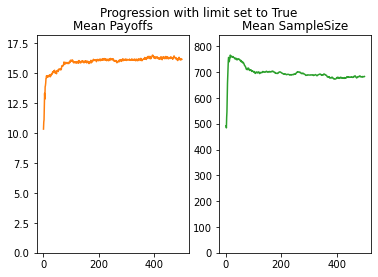

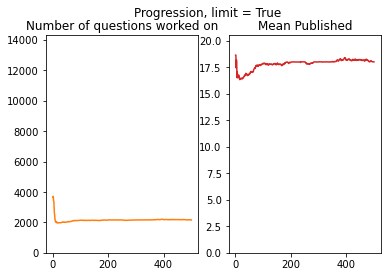

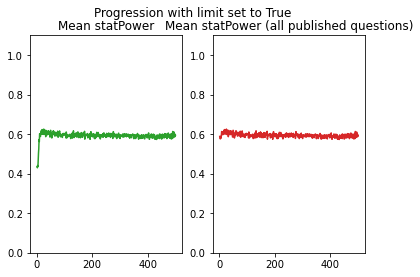

In [9]:
%%time
# track total running time

limit = True
# run model
generationsPlot, nrQuestions, nrQuestionsPub, meanPayoffs, meanSampleSizes, meanPublished, meanPower, meanPowerPub, nrTruePos, nrTrueNeg, nrTruePosPub, nrTrueNegPub, nrFalsePos, nrFalseNeg, nrFalsePosPub, nrFalseNegPub  = evolution (lifeSpanT, scientistPerQuestionMaxT, generationsT, startupCostT, sampleCostT, ExpDistributionShapeT, scoopedCostT, negativeResultCostT, paperLimitT, limit)
# plot mean payoff, mean sample size, mean number of questions worked on, mean number of publications per scientist and mean statistical power for all finished and all published questions
plotGraphs(generationsPlot, meanPayoffs, meanSampleSizes, nrQuestions, meanPublished, meanPower, meanPowerPub)
# store generated data to an Excel file
storeToExcel(limit)

working on generation: 1 / 500
working on generation: 2 / 500
working on generation: 3 / 500
working on generation: 4 / 500
working on generation: 5 / 500
working on generation: 6 / 500
working on generation: 7 / 500
working on generation: 8 / 500
working on generation: 9 / 500
working on generation: 10 / 500
working on generation: 11 / 500
working on generation: 12 / 500
working on generation: 13 / 500
working on generation: 14 / 500
working on generation: 15 / 500
working on generation: 16 / 500
working on generation: 17 / 500
working on generation: 18 / 500
working on generation: 19 / 500
working on generation: 20 / 500
working on generation: 21 / 500
working on generation: 22 / 500
working on generation: 23 / 500
working on generation: 24 / 500
working on generation: 25 / 500
working on generation: 26 / 500
working on generation: 27 / 500
working on generation: 28 / 500
working on generation: 29 / 500
working on generation: 30 / 500
working on generation: 31 / 500
working on genera

working on generation: 253 / 500
working on generation: 254 / 500
working on generation: 255 / 500
working on generation: 256 / 500
working on generation: 257 / 500
working on generation: 258 / 500
working on generation: 259 / 500
working on generation: 260 / 500
working on generation: 261 / 500
working on generation: 262 / 500
working on generation: 263 / 500
working on generation: 264 / 500
working on generation: 265 / 500
working on generation: 266 / 500
working on generation: 267 / 500
working on generation: 268 / 500
working on generation: 269 / 500
working on generation: 270 / 500
working on generation: 271 / 500
working on generation: 272 / 500
working on generation: 273 / 500
working on generation: 274 / 500
working on generation: 275 / 500
working on generation: 276 / 500
working on generation: 277 / 500
working on generation: 278 / 500
working on generation: 279 / 500
working on generation: 280 / 500
working on generation: 281 / 500
working on generation: 282 / 500
working on

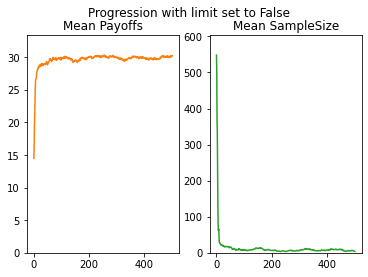

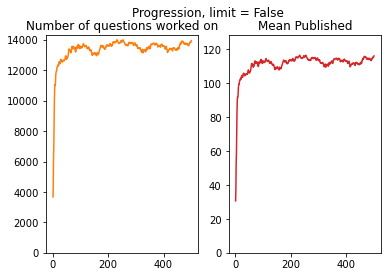

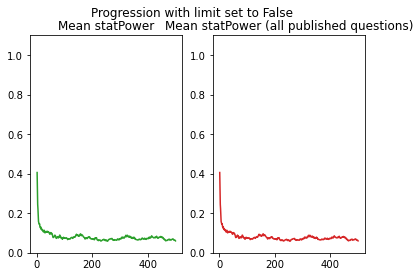

In [10]:
%%time
# track total running time

limit = False
# run model
generationsPlot, nrQuestions, nrQuestionsPub, meanPayoffs, meanSampleSizes, meanPublished, meanPower, meanPowerPub, nrTruePos, nrTrueNeg, nrTruePosPub, nrTrueNegPub, nrFalsePos, nrFalseNeg, nrFalsePosPub, nrFalseNegPub  = evolution (lifeSpanT, scientistPerQuestionMaxT, generationsT, startupCostT, sampleCostT, ExpDistributionShapeT, scoopedCostT, negativeResultCostT, paperLimitT, limit)
# plot mean payoff, mean sample size, mean number of questions worked on, mean number of publications per scientist and mean statistical power for all finished and all published questions
plotGraphs(generationsPlot, meanPayoffs, meanSampleSizes, nrQuestions, meanPublished, meanPower, meanPowerPub)
# store generated data to an Excel file
storeToExcel(limit)

In [11]:
# # run model multiple times
# nrRuns = 1

# limit = True
# print("Limit is TRUE")
# for i in range(nrRuns):
#     # run model
#     generationsPlot, nrQuestions, nrQuestionsPub, meanPayoffs, meanSampleSizes, meanPublished, meanPower, meanPowerPub, nrTruePos, nrTrueNeg, nrTruePosPub, nrTrueNegPub, nrFalsePos, nrFalseNeg, nrFalsePosPub, nrFalseNegPub  = evolution (lifeSpanT, scientistPerQuestionMaxT, generationsT, startupCostT, sampleCostT, ExpDistributionShapeT, scoopedCostT, negativeResultCostT, paperLimitT, limit)
#     # plot mean payoff, mean sample size, mean number of questions worked on, mean number of publications per scientist and mean statistical power for all finished and all published questions
#     plotGraphs(generationsPlot, meanPayoffs, meanSampleSizes, nrQuestions, meanPublished, meanPower, meanPowerPub)
#     # store generated data to an Excel file
#     storeToExcel(limit)
    
# limit = False
# print("Limit is FALSE")
# for i in range(nrRuns):
#     # run model
#     generationsPlot, nrQuestions, nrQuestionsPub, meanPayoffs, meanSampleSizes, meanPublished, meanPower, meanPowerPub, nrTruePos, nrTrueNeg, nrTruePosPub, nrTrueNegPub, nrFalsePos, nrFalseNeg, nrFalsePosPub, nrFalseNegPub  = evolution (lifeSpanT, scientistPerQuestionMaxT, generationsT, startupCostT, sampleCostT, ExpDistributionShapeT, scoopedCostT, negativeResultCostT, paperLimitT, limit)
#     # plot mean payoff, mean sample size, mean number of questions worked on, mean number of publications per scientist and mean statistical power for all finished and all published questions
#     plotGraphs(generationsPlot, meanPayoffs, meanSampleSizes, nrQuestions, meanPublished, meanPower, meanPowerPub)
#     # store generated data to an Excel file
#     storeToExcel(limit)
    
# print("DONE")